# Galaxy Builder analysis Jaccard clustering example

Disks, bulges and bar components in *Galaxy Builder* are clustered using the Jaccard distance, this notebook examines this process.

The [Jaccard Index](https://en.wikipedia.org/wiki/Jaccard_index) is a measure of the relative shared area of two sets, and is defined as

$$J(A, B) = 1 - \frac{|A \cap B|}{|A \cup B|}.$$

We define the Jaccard distance $D_J(A, B) = 1 - J(A, B)$, and use this as a clustering metric.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import MultiPolygon
from descartes import PolygonPatch
from IPython.display import Latex
import gzbuilder_analysis.aggregation as aggregation

In [2]:
e0 = aggregation.make_ellipse(dict(mux=-0.2, muy=0, Re=1, q=0.8, roll=0))
e1 = aggregation.make_ellipse(dict(mux=0.2, muy=0, Re=1, q=0.6, roll=np.pi/3))

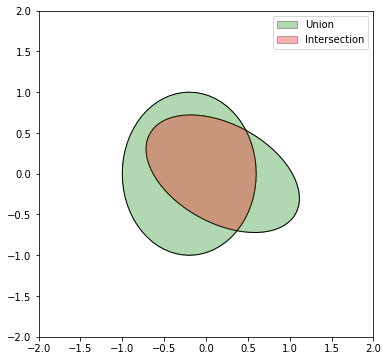

In [3]:
f, ax = plt.subplots(figsize=(6, 6))
ax.add_patch(PolygonPatch(e0, fc='none', ec='k'))
ax.add_patch(PolygonPatch(e1, fc='none', ec='k'))
ax.add_patch(PolygonPatch(e1.union(e0), fc='g', alpha=0.3, label='Union'))
ax.add_patch(PolygonPatch(e1.intersection(e0), fc='r', alpha=0.3, label='Intersection'))
plt.legend()
plt.xlim(-2, 2)
plt.ylim(-2, 2);

These two shapes

In [4]:
Latex(r'$D_J = {:.4f}$'.format(1 - e0.intersection(e1).area / e0.union(e1).area))

<IPython.core.display.Latex object>

This metric can then be used with clustering algorithms to group similar shapes. For instance, if we have a cluster of 10 ellipses and two outliers, we can use DBSCAN to identify the outliers:

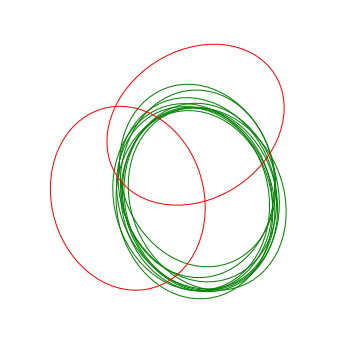

In [5]:
from sklearn.cluster import DBSCAN 
def make_jittered_ellipse(p, sigma_p):
    p_ = p + np.random.randn(len(sigma_p)) * sigma_p
    return aggregation.make_ellipse(p_)

p = pd.Series(dict(mux=0, muy=0, Re=1, q=0.8, roll=0.2))
sigma_p=pd.Series(dict(mux=0.05, muy=0.1, Re=0.01, q=0.001, roll=0.1))

ellipses = pd.Series([make_jittered_ellipse(p, sigma_p) for _ in range(10)])

p_outlier0 = pd.Series(dict(mux=-0.7, roll=0.3)).combine_first(p)
p_outlier1 = pd.Series(dict(muy=0.6, roll=-np.pi/3)).combine_first(p)
outliers = pd.Series([
    make_jittered_ellipse(p_outlier0, sigma_p),
    make_jittered_ellipse(p_outlier1, sigma_p)
])

sample = pd.concat((ellipses, outliers), axis=0, ignore_index=True)

jaccard_array = aggregation.jaccard.make_jaccard_distances(sample)
labels = DBSCAN(eps=0.4, metric='precomputed').fit(jaccard_array).labels_


f, ax = plt.subplots(figsize=(6, 6))
for e, l in zip(sample, labels):
    ax.add_patch(PolygonPatch(e, fc='none', ec=('g' if l != -1 else 'r')))
plt.xlim(-2, 1.5)
plt.ylim(-1.5, 2)
plt.axis('off');

We can then define the "aggregate" ellipse as the one that minimizes the sum of Jaccard distances to all the ellipses identified in the cluster:

In [6]:
def f(p):
    p = pd.Series(p, ('mux', 'muy', 'Re', 'q', 'roll'))
    this_ellipse = aggregation.make_ellipse(p)
    return sum(
        aggregation.jaccard.jaccard_distance(this_ellipse, e)
        for e in sample[labels==0].values
    )

from scipy.optimize import minimize

res = minimize(f, (0, 0, 1, 1, 0))
aggregate_ellipse = pd.Series(res['x'], ('mux', 'muy', 'Re', 'q', 'roll'))

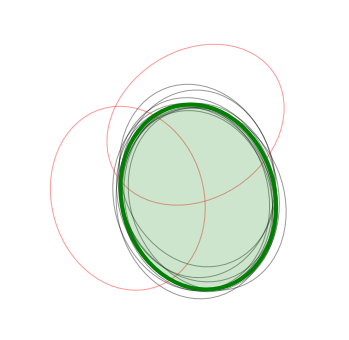

In [7]:
f, ax = plt.subplots(figsize=(6, 6))
for e, l in zip(sample, labels):
    ax.add_patch(PolygonPatch(e, fc='none', ec=('k' if l != -1 else 'r'), alpha=0.4))
ax.add_patch(PolygonPatch(
    aggregation.make_ellipse(aggregate_ellipse),
    fc='g', ec='none', alpha=0.2
))
ax.add_patch(PolygonPatch(
    aggregation.make_ellipse(aggregate_ellipse),
    fc='none', ec='g', lw=4
))
plt.xlim(-2, 1.5)
plt.ylim(-1.5, 2)
plt.axis('off');

And there we go! This is the underlying mechanism by which we cluster disks, bulges and bars.

One drawback is that for highly elliptical components (i.e. bars), the Jaccard distance becomes very sensitive to rotation, suggesting a better metric might combine Jaccard distance to "centre of mass distance" or something similar.